In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

if not os.path.exists("dataset"):
    os.mkdir("dataset")

# download dataset and save to dataset folder
! unzip /content/drive/MyDrive/Landmark_Retrieval.zip -d dataset
! unzip /content/drive/MyDrive/classifier.zip


In [ ]:
# install packages
! pip install transformers
! pip install datasets

## Load image and pre-processing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import ViTForImageClassification, ViTConfig, Trainer, TrainingArguments, ViTFeatureExtractor
from datasets import load_dataset, load_metric
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
dataset_dir = '/content/dataset/Landmark_Retrieval/train'
dataset = load_dataset(dataset_dir)

# retrieval dataset's labels and create 2 dict
labels = dataset['train'].features['label'].names
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}

In [ ]:
labels

['bao_tang_ha_noi',
 'buu_dien_trung_tam_tphcm',
 'cau_long_bien',
 'cau_nhat_tan',
 'cau_rong',
 'cho_ben_thanh_tphcm',
 'chua_cau',
 'chua_mot_cot',
 'chua_thien_mu',
 'cot_co',
 'hoang_thanh',
 'hon_chong_nhatrang',
 'landmark81',
 'lang_bac',
 'lang_khai_dinh',
 'mui_ca_mau',
 'mui_ke_ga_phanthiet',
 'nha_hat_lon_hanoi',
 'nha_hat_lon_tphcm',
 'nha_tho_da_co_sapa',
 'nha_tho_lon_ha_noi',
 'quang_truong_lam_vien',
 'suoi_tien_tphcm',
 'thac_ban_gioc',
 'thap_cham',
 'thap_rua',
 'toa_nha_bitexco_tphcm',
 'tuong_chua_kito_vungtau',
 'ubnd_tphcm',
 'van_mieu']

In [ ]:
# split dataset to train, val, test dataset
def split_dataset(dataset, train_size=0.8, test_size=0.1, val_size=0.1):
    # split train and test dataset
    splits = dataset['train'].train_test_split(test_size=test_size+val_size)
    train_data, test_data = splits['train'], splits['test']

    # split test and val dataset
    splits = test_data.train_test_split(test_size=val_size/(test_size+val_size))
    val_data, test_data = splits['train'], splits['test']

    return train_data, val_data, test_data

train_data, val_data, test_data = split_dataset(dataset)

In [ ]:
# transform data to correct 
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

processed_train_data = train_data.with_transform(transform)
processed_val_data = val_data.with_transform(transform)
processed_test_data = test_data.with_transform(transform)

## Display the dataset

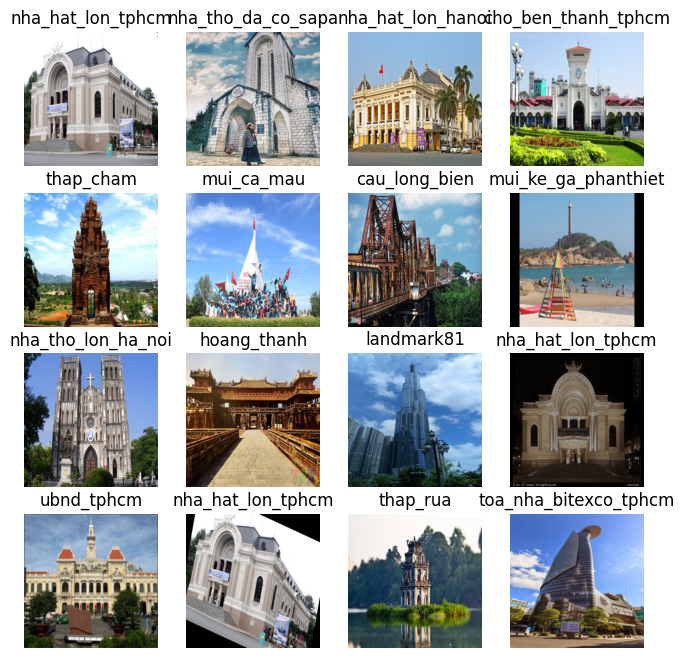

In [ ]:
# Display the images in a grid
def show_images_grid(dataset, grid_size=(4,4)):
    indices = random.sample(range(len(dataset['train'])), grid_size[0] * grid_size[1])
    images = [dataset['train'][i]['image'] for i in indices]
    _labels = [dataset['train'][i]['label'] for i in indices]

    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        image = images[i].resize((224,224))
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(labels[_labels[i]])
    
    plt.show()
show_images_grid(dataset)

## Fine-tuned ViT Image Classifier

In [ ]:
model_name='google/vit-base-patch16-224-in21k'

# load ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
model_name = 'google/vit-base-patch16-224-in21k'

# load ViT Image Classification
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training argument
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    evaluation_strategy ='steps',
    num_train_epochs=10,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    logging_dir="./logs",
    save_total_limit=5,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
}

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

# trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_train_data,
    eval_dataset=processed_val_data,
    tokenizer=feature_extractor,
)

<ipython-input-12-88b52c57c8a8>:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.563100,0.546143,0.986667
200,0.127500,0.171108,0.980000
300,0.067700,0.105571,0.986667
400,0.042900,0.078177,0.993333
500,0.033500,0.068338,0.993333
600,0.028600,0.062583,0.993333
700,0.026200,0.060025,0.993333


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should b

## Run on Test dataset

In [ ]:
metrics = trainer.evaluate(processed_test_data)
outputs = trainer.predict(processed_test_data)
y_pred = outputs.predictions.argmax(1)

print('evaluation on test dataset has result: ',metrics)

evaluation on test dataset has result:  {'eval_loss': 0.0366973876953125, 'eval_accuracy': 1.0, 'eval_runtime': 9.0765, 'eval_samples_per_second': 16.526, 'eval_steps_per_second': 2.093, 'epoch': 10.0}


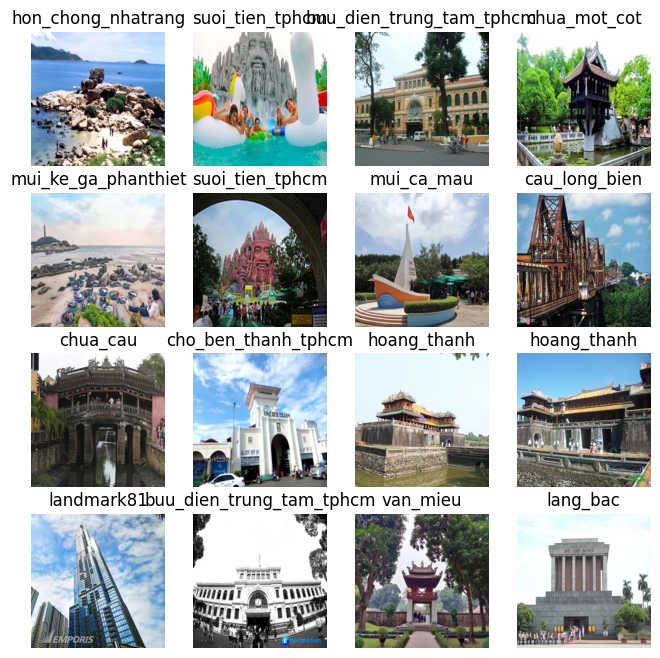

In [ ]:
# function to display image with its prediction
def display_image_prediction(dataset, y_pred):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        image = dataset[i]['image'].resize((224,224))
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(labels[y_pred[i]])
display_image_prediction(test_data, y_pred)

## Save model

In [ ]:
trainer.save_model('classifier')
! zip -r classifier.zip classifier

  adding: classifier/ (stored 0%)
  adding: classifier/preprocessor_config.json (deflated 46%)
  adding: classifier/pytorch_model.bin (deflated 7%)
  adding: classifier/training_args.bin (deflated 49%)
  adding: classifier/config.json (deflated 62%)


## Load model

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch

model_dir = '/content/classifier'

# Load the model from the pytorch_model.bin file
model = ViTForImageClassification.from_pretrained(model_dir)

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(model_dir)

# Set the model to evaluation mode
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['image_name', 'prediction'])

## Preprocess database

In [ ]:
from PIL import Image

# load database
database_dir = '/content/dataset/Landmark_Retrieval/test/database'

# remove null file, trash file
# ! rm '/content/dataset/Landmark_Retrieval/test/database/c024e78ff1d74390.jpg'

database = load_dataset(database_dir)

predicted = []
img_paths = []
for filename in tqdm(os.listdir(database_dir)):
    full_path = os.path.join(database_dir, filename)
    img_paths.append(full_path)
    if os.path.isfile(full_path):
        img = Image.open(full_path)
        
        if img.mode != 'RGB':
            img = img.convert('RGB')
            
        input = feature_extractor(images=img, return_tensors="pt")
        input = input.to(device)
        
        # feature extraction
        output=model(**input)

        # prediction
        logits = output.logits
        predicted_class_idx = logits.argmax(-1).item()
        df.loc[len(df.index)] = [filename, predicted_class_idx]
        predicted.append(predicted_class_idx)

Resolving data files:   0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [01:08<00:00, 17.62it/s]


In [ ]:
# store and download predicted list into a file
import pickle 
with open('dataframe.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
# to open a pickle file storing your list
import pickle
with open('predicted.pkl', 'rb') as f:
    predicted2 = pickle.load(f)
  
print(predicted2)

[10, 21, 4, 3, 20, 1, 26, 3, 7, 28, 1, 16, 6, 12, 18, 17, 16, 1, 19, 3, 1, 22, 27, 4, 4, 8, 11, 25, 22, 10, 13, 24, 19, 17, 28, 6, 18, 21, 23, 20, 20, 9, 19, 3, 24, 3, 23, 20, 28, 14, 9, 29, 18, 9, 2, 17, 24, 24, 0, 14, 1, 4, 19, 19, 24, 24, 26, 29, 8, 21, 7, 17, 26, 14, 8, 0, 20, 10, 29, 26, 22, 22, 21, 13, 8, 24, 12, 29, 24, 15, 28, 11, 12, 28, 11, 7, 3, 5, 14, 2, 11, 12, 17, 15, 25, 0, 22, 7, 3, 14, 6, 12, 12, 0, 2, 25, 4, 25, 25, 22, 2, 6, 2, 13, 28, 6, 28, 9, 7, 3, 27, 0, 2, 9, 6, 13, 24, 26, 18, 0, 28, 4, 11, 4, 13, 13, 2, 14, 26, 25, 17, 21, 23, 20, 2, 25, 27, 20, 26, 7, 23, 5, 0, 13, 29, 18, 2, 16, 25, 29, 13, 26, 1, 25, 8, 18, 0, 6, 4, 29, 27, 6, 13, 14, 5, 25, 19, 29, 11, 22, 12, 2, 24, 28, 20, 7, 21, 23, 26, 2, 27, 2, 1, 9, 13, 26, 4, 2, 8, 9, 22, 20, 11, 8, 19, 9, 23, 8, 12, 1, 27, 12, 11, 5, 28, 23, 4, 6, 5, 0, 17, 14, 9, 24, 8, 29, 16, 15, 6, 18, 2, 9, 1, 15, 18, 12, 18, 18, 12, 17, 20, 29, 15, 23, 18, 19, 25, 26, 9, 15, 29, 9, 27, 2, 14, 23, 26, 14, 9, 29, 23, 11, 17, 17

In [ ]:
# create dataframe with image and prediction columns
import pandas as pd
database_dir = '/content/dataset/Landmark_Retrieval/test/database'
db_images = [filename for filename in os.listdir(database_dir)]
df = pd.DataFrame({'image': db_images, 'prediction': predicted2})

In [ ]:
import tensorflow as tf
fname = os.listdir(database_dir)[0]

full_path = os.path.join(database_dir, fname)
img = Image.open(full_path)

#img = tf.image.decode_image(img, channels=3)
if img.mode != 'RGB':
    img = img.convert('RGB')

input = feature_extractor(images=img, return_tensors="pt")
input = input.to(device)

# feature extraction
output=model(**input)

# prediction
logits = output.logits
predicted_class_idx = logits.argmax(-1).item()
labels[predicted_class_idx]

'hoang_thanh'